In [6]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing

In [12]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrain, labelTrain), (imageTest, labelTest) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTest = imageTest[:]
labelTest = labelTest[:]

imageValid = imageTrain[55000:]
labelValid = labelTrain[55000:]

imageTrain = imageTrain[:55000]
labelTrain = labelTrain[:55000]

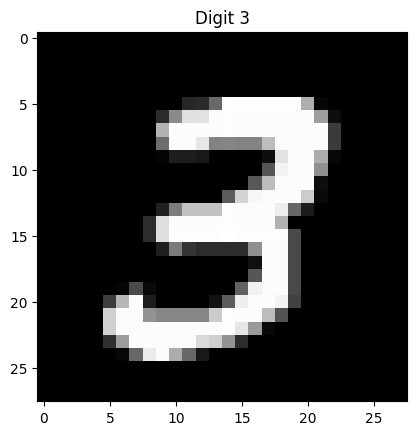

In [13]:
# Visualizing data
# Printing an array
def printArr(idx):
    to_write = ""
    for i in range(28):
        for j in range(28):
            if(len(str(imageTrain[idx][i][j])) == 1):
                to_write += str(imageTrain[idx][i][j]) + "    "
            elif(len(str(imageTrain[idx][i][j])) == 2):
                to_write += str(imageTrain[idx][i][j]) + "   "
            else:
                to_write += str(imageTrain[idx][i][j]) + "  "
        to_write += "\n"
    to_write += f"\nDigit: {labelTrain[idx]}"
    with open("./test/imageArr.txt", "w") as file:
        file.write(to_write)
        
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrain[idx]}")
    pyplot.imshow(imageTrain[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")

idx = 7
printArr(idx)
plotImage(idx)

In [14]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
# imageTest = np.reshape(imageTest, (10000, 784))
# imageTest = preprocessing.normalize(imageTest, norm = "max")
labelTest = tf.keras.utils.to_categorical(labelTest, num_classes=10)

# imageValid = np.reshape(imageValid, (5000, 784))
# imageValid = preprocessing.normalize(imageValid, norm = "max")
labelValid = tf.keras.utils.to_categorical(labelValid, num_classes=10)

# imageTrain = np.reshape(imageTrain, (55000, 784))
# imageTrain = preprocessing.normalize(imageTrain, norm="max")
labelTrain = tf.keras.utils.to_categorical(labelTrain, num_classes=10)

In [69]:
# Implementing a convolutional neural network with 1 convolution layer and 1 pooling layer
class CNN:
    def __init__(self, batchSize, iterations, learningRate):
        # Initializing model hyperparameters
        self.batchSize, self.iterations, self.learningRate = batchSize, iterations, learningRate
        self.stride = 1          # Stride for convolution layer
        self.padding = 0         # Padding for convolution layer
        self.kernelDim = 3       # Dimension of kernel = 3 x 3
        self.kernelNum = 5       # Number of kernels (filters)
        self.inputDim = 28       # Dimension of input images = 28 x 28
        self.featureDim = 26     # Dimension of feature map = inputDim + 2 * padding - kernelDim) / stride + 1 
        self.outputDim = 10      # Dimension of output results = 10 x 1
        self.sizeTest = 10000    # Size of test set
        self.sizeValid = 5000    # Size of validation set
        self.sizeTrain = 55000   # Size of training set
    
    # Convolution layer
    def convolution(self, x, kernelList):
        result = np.zeros((self.kernelNum, self.featureDim, self.featureDim))
        
        for n in range(self.kernelNum):
            for i in range(self.featureDim):
                for j in range(self.featureDim):
                    result[n, i, j] = np.sum(np.multiply(kernelList[n], x[i : i + self.kernelDim, j : j + self.kernelDim]))
        return result
    
    # Nonlinear layer using ReLU activation
    def relu(self, x):
        return np.maximum(x, 0)
    
    def softmax(self, x):
        c = np.max(x, axis = 0, keepdims=True)
        x -= c
        e = np.exp(x)
        return e / np.sum(e, axis = 0, keepdims=True)
    
    def forwardfeed(self, x, y):
        ''' input -- x: training data input x, size of (784,)
                     y: training data output y, integer
            output-- a dictionary of Z, H, U, f_X, error
        '''
        v = self.convolution(x, self.kernelList) # Feature map
        z = (self.relu(v)).T # Feature map after ReLU
        print(z.shape)
        a = np.dot(self.w, z) + self.b
        y = self.softmax(a)
        #error = self.cross_entropy_error(predict_list, y)
        return (v, z, a, y)
    
    def train(self, xTrain, yTrain):
        # Initializing random weights and biases for output layer
        # Dimension of weight is 10 x 3380 to map convolution layer (x) to output layer (y) 
        self.w = 0.01 * np.random.randn(self.outputDim, self.kernelNum * self.featureDim ** 2)
        # Dimension of bias is 10 x 1
        self.b = 0.01 * np.random.randn(self.outputDim, 1)
        # Initializing random kernels for convolutional layer
        self.kernelList = []
        for n in range(self.kernelNum):
            kernel = 0.01 * np.random.randn(self.kernelDim, self.kernelDim)
            self.kernelList.append(kernel)
            
        # print(self.W)
        # print(self.b)
        # print(self.kernelList)
        
        # Generating a random list of indices for the training set
        idxList = np.random.randint(low=0, high=self.sizeTrain, size=self.batchSize)

        count = 0
        lossDict = {}
        tesDict = {}

        for i in idxList:
            resultFF = self.forwardfeed(xTrain[i], yTrain[i])
            resultBP = self.backpropagation(xTrain[i], yTrain[i], resultFF)
            
            self.w -= self.learningRate * resultBP['dW']
            self.b -= self.learningRate * resultBP['db']
            for i in range(self.kernelNum):
                self.kernels[i] -= self.learningRate * resultBP['dK'][i]
            
            # if count % 100 == 0:
            #     if count % 30000 == 0:
            #         loss = self.loss(x_test,y_test)
            #         test = self.testing(x_test,y_test)
            #         print('Trained for {} times,'.format(count),'loss = {}, test = {}'.format(loss,test))
            #         # loss_dict[str(count)]=loss
            #         test_dict[str(count)]=test
            #     else:
            #         print('Trained for {} times,'.format(count))
            count += 1

        print("Training finished!")
        return lossDict, tesDict
    
model = CNN(batchSize=50, iterations=10, learningRate=0.05)
model.train(imageTrain, labelTrain)

(5, 26, 26)


ValueError: shapes (10,3380) and (5,26,26) not aligned: 3380 (dim 1) != 26 (dim 1)